<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/3_3_3_4_Data_Deiriving_and_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chicago Crime 2017 — Feature Engineering (Figures 34–40) & Data Integration (Table 4)

**Environment:** PySpark on Google Colab.  
**Input CSV:** `/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv`  
**Outputs:** figures in `/content/drive/MyDrive/Infosys 722/figs/`, tables in `/content/drive/MyDrive/Infosys 722/tables/`.

This notebook computes calendar/ratio/momentum features in **PySpark**, then converts small aggregates to pandas for plotting in **Matplotlib**. It reproduces **Figures 34–40** and **Table 4** in the report.

In [16]:
# === 0) Colab & library setup ===
# Mount Google Drive and install PySpark (Colab typically downloads quickly).
from google.colab import drive
drive.mount('/content/drive')

!pip -q install pyspark==3.5.1

import os, numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, functions as F, types as T, Window

# Paths
BASE_DIR = "/content/drive/MyDrive/Infosys 722"
CSV_PATH = f"{BASE_DIR}/CrimeData_2017.csv"
FIG_DIR = f"{BASE_DIR}/figs"
TABLE_DIR = f"{BASE_DIR}/tables"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

# Matplotlib defaults for consistent look
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

print("Input:", CSV_PATH)
print("Figures ->", FIG_DIR)
print("Tables  ->", TABLE_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input: /content/drive/MyDrive/Infosys 722/CrimeData_2017.csv
Figures -> /content/drive/MyDrive/Infosys 722/figs
Tables  -> /content/drive/MyDrive/Infosys 722/tables


In [17]:
# === 1) Create Spark session and read CSV ===
spark = SparkSession.builder.appName("Crime2017_FeatureEng").getOrCreate()

# Read with header and schema inference; columns follow Kaggle's Chicago crime export
df = spark.read.csv(CSV_PATH, header=True, inferSchema=True, multiLine=True, escape='"')
print("Raw columns:", df.columns[:10], "... (total:", len(df.columns), ")")

# Canonicalize a few column names (guard against spaces/casing differences)
rename_map = {
    'Primary Type':'Primary Type',
    'Location Description':'Location Description',
    'X Coordinate':'X Coordinate',
    'Y Coordinate':'Y Coordinate',
}
for old, new in rename_map.items():
    if old in df.columns and new != old:
        df = df.withColumnRenamed(old, new)

# Parse the Date into a timestamp; try common Chicago formats then fall back
df = df.withColumn(
    "ts",
    F.coalesce(
        F.to_timestamp(F.col("Date"), "MM/dd/yyyy hh:mm:ss a"),
        F.to_timestamp(F.col("Date"), "MM/dd/yyyy HH:mm:ss"),
        F.to_timestamp(F.col("Date"))
    )
)

# Filter to 2017 only (the study scope)
df = df.withColumn("year", F.year("ts")).filter(F.col("year") == 2017)

# Calendar fields
df = (
    df.withColumn("month", F.month("ts"))
      .withColumn("hour", F.hour("ts"))
)

# Hour bins: 00–05, 06–11, 12–17, 18–23 (strings for categorical semantics)
df = df.withColumn(
    "HourBin",
    F.when((F.col("hour")>=0) & (F.col("hour")<=5),  F.lit("00-05"))
     .when((F.col("hour")>=6) & (F.col("hour")<=11), F.lit("06-11"))
     .when((F.col("hour")>=12) & (F.col("hour")<=17),F.lit("12-17"))
     .otherwise(F.lit("18-23"))
)

# Arrest & Domestic to numeric 0/1 (robust to string/boolean types)
def to01(col):
    return F.coalesce(F.col(col).cast("int"), F.when(F.lower(F.col(col))=="true", 1).otherwise(0))

df = df.withColumn("Arrest01", to01("Arrest")).withColumn("Domestic01", to01("Domestic"))

# "Outdoor" flag derived from Location Description (broad, conservative mapping)
outdoor_patterns = (
    "STREET|SIDEWALK|ALLEY|PARK|PARKING|LOT|GAS STATION|PUBLIC WAY|HIGHWAY|BRIDGE|BEACH|AIRPORT|YARD"
)
df = df.withColumn(
    "Outdoor01",
    F.when(F.upper(F.col("Location Description")).rlike(outdoor_patterns), 1).otherwise(0)
)

df.cache()
print("Rows in scope (2017):", df.count())

Raw columns: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic'] ... (total: 22 )
Rows in scope (2017): 267562


In [18]:
# === 2) Aggregations for engineered features ===

# 2.1 District-Month counts and rates
dm = (
    df.groupBy("District", "month")
      .agg(
          F.count("*").alias("n"),
          F.avg("Arrest01").alias("ArrestRate"),
          F.avg("Domestic01").alias("DomesticRate"),
          F.sum(
              F.when((F.col("hour")>=18) | (F.col("hour")<=5), 1).otherwise(0)
          ).alias("NightCount")
      )
      .withColumn("NightShare", F.col("NightCount")/F.col("n"))
)

# 2.2 Beat-to-District share per month
beat_dm = df.groupBy("District", "Beat", "month").agg(F.count("*").alias("BeatCount"))
dm_cnt = dm.select("District", "month", "n").withColumnRenamed("n", "DistrictMonthCount")
beat_share = (
    beat_dm.join(dm_cnt, on=["District","month"], how="inner")
            .withColumn("Beat_to_District_Share", F.col("BeatCount")/F.col("DistrictMonthCount"))
)

# 2.3 Outdoor share per district-month
outdoor_dm = (
    df.groupBy("District","month")
      .agg(
          F.avg("Outdoor01").alias("OutdoorShare")
      )
)

# 2.4 Type share by month (top N types by annual volume)
type_total = df.groupBy("Primary Type").agg(F.count("*").alias("total")).orderBy(F.desc("total"))
top_types = [r[0] for r in type_total.limit(7).collect()]
type_month = (
    df.filter(F.col("Primary Type").isin(top_types))
      .groupBy("month", "Primary Type").agg(F.count("*").alias("cnt"))
)
month_total = df.groupBy("month").agg(F.count("*").alias("m_total"))
type_share = type_month.join(month_total, on=["month"], how="inner")\
                     .withColumn("TypeShare", F.col("cnt")/F.col("m_total"))

# 2.5 Rolling mean of counts by district (3-month window, inclusive)
dm_counts = df.groupBy("District","month").agg(F.count("*").alias("Count_DistMonth"))
w = Window.partitionBy("District").orderBy("month").rowsBetween(-2,0)
dm_roll = dm_counts\
    .withColumn("roll3_mean", F.avg("Count_DistMonth").over(w))\
    .select("District","month","Count_DistMonth","roll3_mean")

print("Prepared aggregates: dm, beat_share, outdoor_dm, type_share, dm_roll")

Prepared aggregates: dm, beat_share, outdoor_dm, type_share, dm_roll


In [19]:
# Helpers
import numpy as np
def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, bbox_inches='tight')
    print("Saved:", path)
    plt.show()

def to_pandas(sdf):
    return sdf.toPandas()

Saved: /content/drive/MyDrive/Infosys 722/figs/fig34_top12_arrest_rate.png


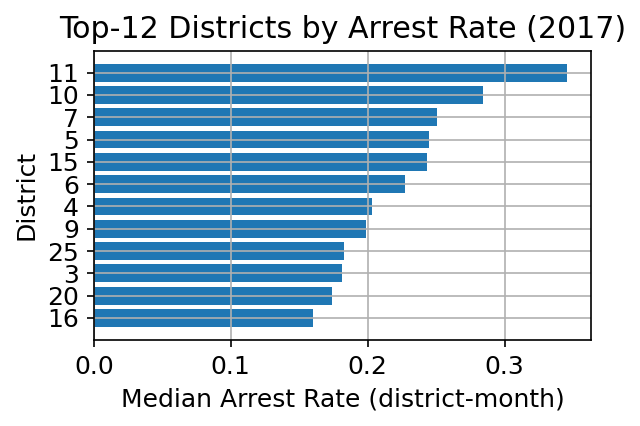

In [20]:
# === Figure 34 ===
median_dm = dm.groupBy("District").agg(F.expr("percentile_approx(ArrestRate, 0.5)").alias("MedianArrestRate"))
top12 = median_dm.orderBy(F.desc("MedianArrestRate")).limit(12)
pdf = to_pandas(top12).sort_values("MedianArrestRate", ascending=True)
plt.figure(figsize=(4.2,3.0))
plt.barh(pdf["District"].astype(str), pdf["MedianArrestRate"])
plt.title("Top-12 Districts by Arrest Rate (2017)")
plt.xlabel("Median Arrest Rate (district-month)")
plt.ylabel("District")
savefig("fig34_top12_arrest_rate.png")

Saved: /content/drive/MyDrive/Infosys 722/figs/fig35_beat_share_hist.png


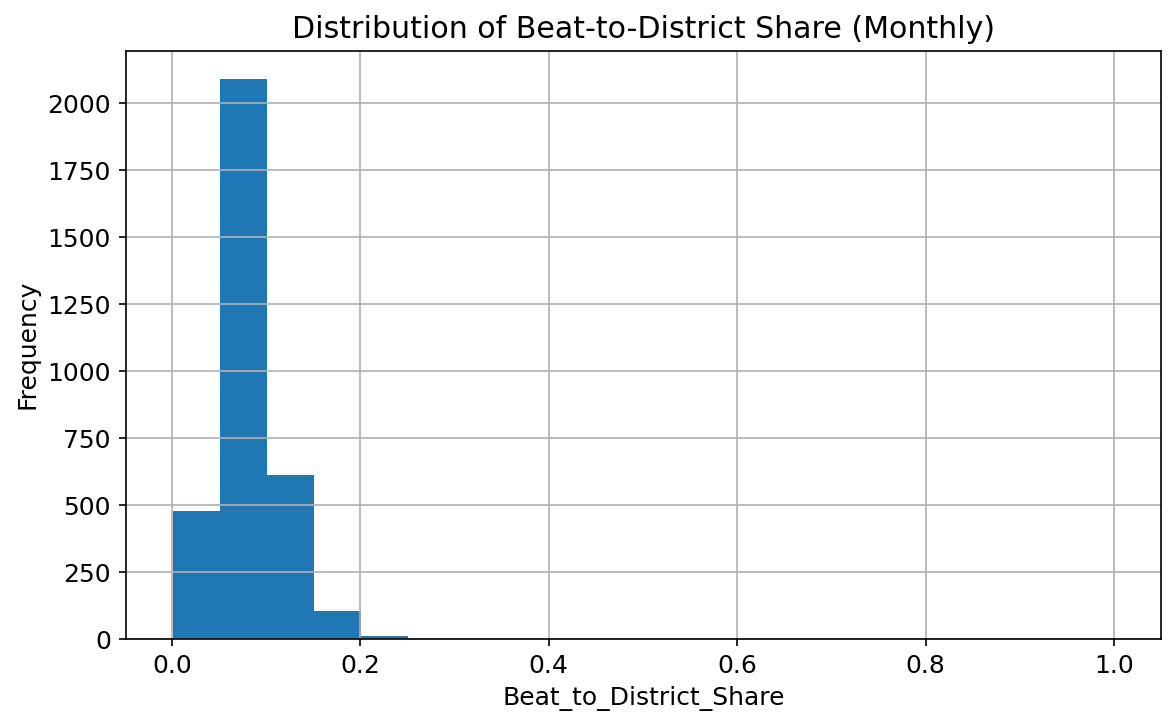

In [21]:
# === Figure 35 ===
pdf = to_pandas(beat_share.select("Beat_to_District_Share"))
plt.figure(figsize=(8,5))
plt.hist(pdf["Beat_to_District_Share"].dropna(), bins=20)
plt.title("Distribution of Beat-to-District Share (Monthly)")
plt.xlabel("Beat_to_District_Share")
plt.ylabel("Frequency")
savefig("fig35_beat_share_hist.png")

Saved: /content/drive/MyDrive/Infosys 722/figs/fig36_nightshare_hist.png


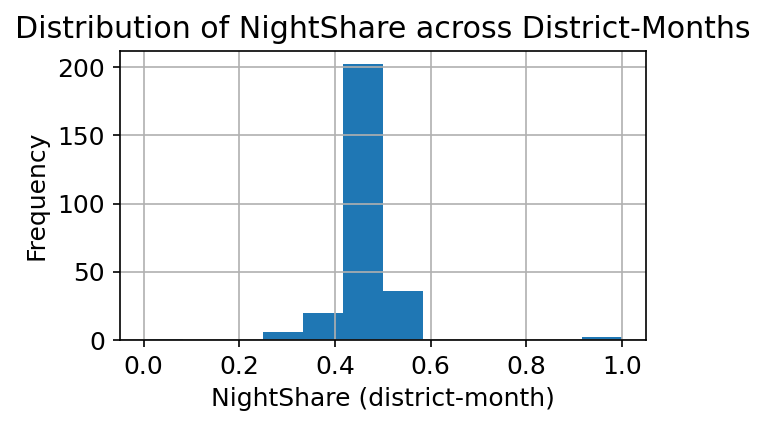

In [22]:
# === Figure 36 ===
pdf = to_pandas(dm.select("NightShare"))
plt.figure(figsize=(4.5,3.0))
plt.hist(pdf["NightShare"].dropna(), bins=12)
plt.title("Distribution of NightShare across District-Months")
plt.xlabel("NightShare (district-month)")
plt.ylabel("Frequency")
savefig("fig36_nightshare_hist.png")

Saved: /content/drive/MyDrive/Infosys 722/figs/fig37_outdoorshare_box.png


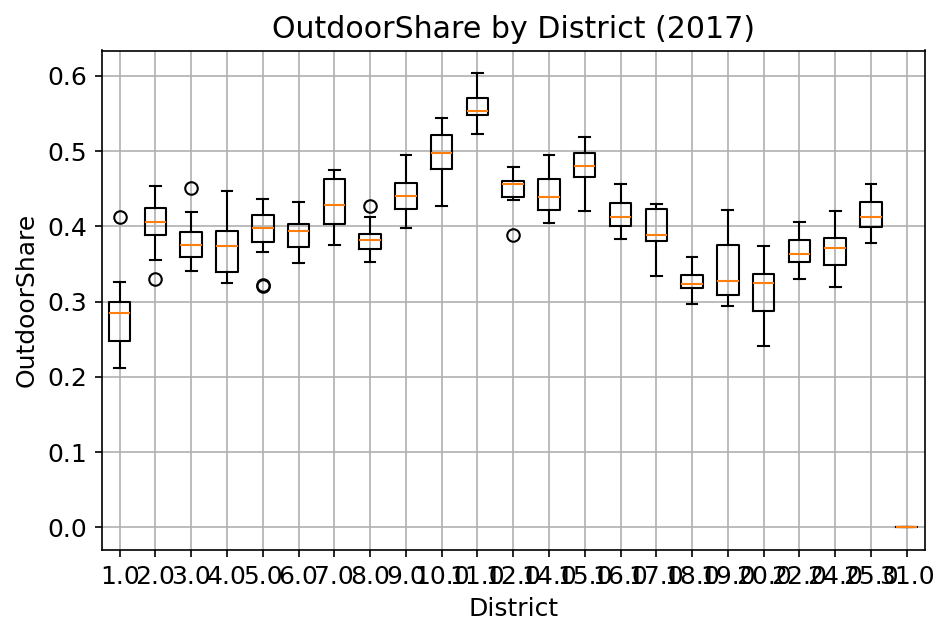

In [23]:
# === Figure 37 ===
pdf = to_pandas(outdoor_dm)
plt.figure(figsize=(6.5,4.4))
order = sorted(pdf["District"].dropna().unique())
data = [pdf.loc[pdf["District"]==d, "OutdoorShare"].values for d in order]
plt.boxplot(data, positions=np.arange(len(order))+1, widths=0.6, showfliers=True)
plt.xticks(np.arange(len(order))+1, [str(d) for d in order])
plt.xlabel("District")
plt.ylabel("OutdoorShare")
plt.title("OutdoorShare by District (2017)")
savefig("fig37_outdoorshare_box.png")

Saved: /content/drive/MyDrive/Infosys 722/figs/fig38_type_share_heatmap.png


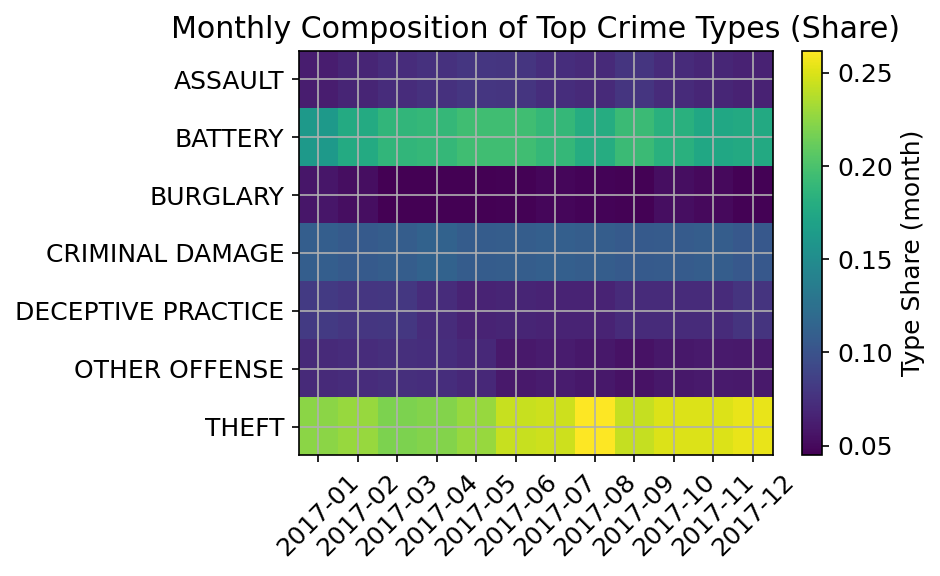

In [24]:
# === Figure 38 ===
pdf = to_pandas(type_share)
import numpy as np
pivot = pdf.pivot_table(index="Primary Type", columns="month", values="TypeShare", fill_value=0)
plt.figure(figsize=(6.4,4.0))
plt.imshow(pivot.values, aspect='auto')
plt.colorbar(label="Type Share (month)")
plt.yticks(np.arange(pivot.shape[0]), pivot.index)
plt.xticks(np.arange(12), [f"2017-{m:02d}" for m in range(1,13)], rotation=45)
plt.title("Monthly Composition of Top Crime Types (Share)")
savefig("fig38_type_share_heatmap.png")

Saved: /content/drive/MyDrive/Infosys 722/figs/fig39_rolling_mean_district.png


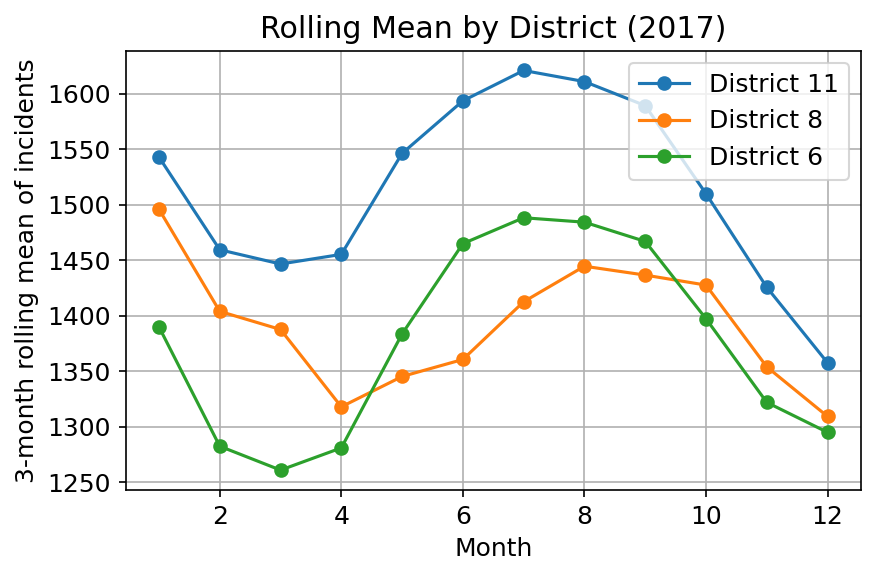

In [25]:
# === Figure 39 ===
sel = [11,8,6]
pdf = to_pandas(dm_roll.filter(F.col("District").isin(sel)).orderBy("District","month"))
plt.figure(figsize=(6.0,4.0))
for d in sel:
    sub = pdf[pdf["District"]==d]
    plt.plot(sub["month"], sub["roll3_mean"], marker='o', label=f"District {d}")
plt.legend()
plt.xlabel("Month")
plt.ylabel("3-month rolling mean of incidents")
plt.title("Rolling Mean by District (2017)")
savefig("fig39_rolling_mean_district.png")

## Data Integration Simulation (Table A, Table B, Merge) — Table 4 and Figure 40

In [30]:
# === Rebuild a clean 22-column ORIGINAL dataframe from CSV ===
# We normalize column names to handle minor variations (spaces, cases).
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

DATA_PATH = "/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv"

# Read CSV freshly to avoid any prior mutations on df
df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

# Canonical 22 base columns in the Chicago Crimes dataset
canonical_cols = [
    "ID","Case Number","Date","Block","IUCR","Primary Type","Description",
    "Location Description","Arrest","Domestic","Beat","District","Ward",
    "Community Area","FBI Code","X Coordinate","Y Coordinate","Year",
    "Updated On","Latitude","Longitude","Location"
]

# Helper: normalize column names (lowercase, remove non-alphanumerics)
def norm(s):
    return "".join(ch.lower() for ch in s if ch.isalnum())

raw_norm_map = {norm(c): c for c in df_raw.columns}  # normalized -> actual

# Build a mapping from canonical -> actual column name in df_raw
found = {}
missing = []
for c in canonical_cols:
    key = norm(c)
    if key in raw_norm_map:
        found[c] = raw_norm_map[key]   # actual name in df_raw
    else:
        missing.append(c)

if missing:
    print("WARNING: Missing columns in your CSV:", missing)

# Select only the canonical 22 columns (those that are present)
select_exprs = [F.col(found[c]).alias(c) for c in canonical_cols if c in found]
df_base = df_raw.select(*select_exprs)

print("df_raw columns:", len(df_raw.columns))
print("df_base (restricted to canonical set) columns:", len(df_base.columns))
print("Sample of df_base columns:", df_base.columns[:10])
print("Row count:", df_base.count())


df_raw columns: 22
df_base (restricted to canonical set) columns: 22
Sample of df_base columns: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic']
Row count: 267562


Saved Figure 40: /content/drive/MyDrive/Infosys 722/figs/fig40_integration_sizes.png


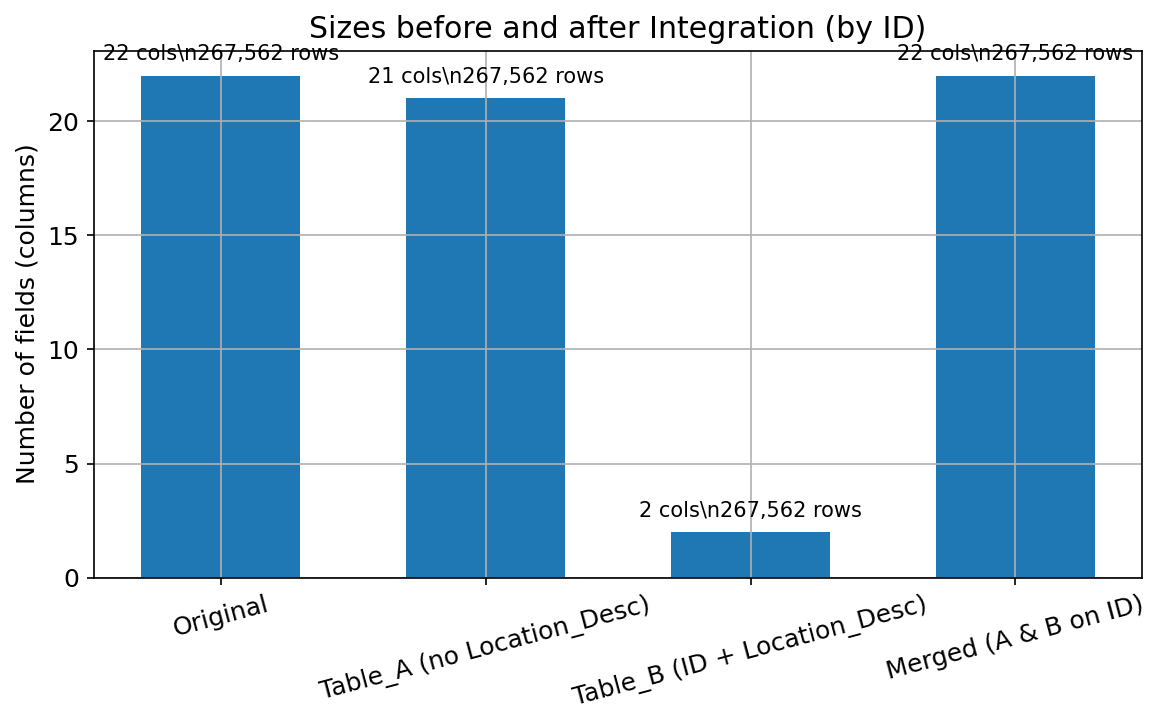

In [31]:
# === Build A/B/Merged from the 22-column base, then plot Figure 40 ===
import numpy as np, os
import matplotlib.pyplot as plt

FIG_DIR = "/content/drive/MyDrive/Infosys 722/figs"
os.makedirs(FIG_DIR, exist_ok=True)

id_col = "ID"
locdesc_col = "Location Description"

# A: drop Location Description -> 21 cols
A = df_base.drop(locdesc_col)

# B: keep only ID and Location Description -> 2 cols
B = df_base.select(id_col, locdesc_col)

# Merged: left join on ID -> back to 22 cols
Merged = A.join(B, on=id_col, how="left")

def n_rows(sdf): return sdf.count()
def n_cols(sdf): return len(sdf.columns)
def n_dup_ids(sdf):
    return sdf.groupBy(id_col).count().filter(F.col("count") > 1).count()
def n_unique_ids(sdf):
    return sdf.select(id_col).distinct().count()

import pandas as pd
sizes_pd = pd.DataFrame([
    {"Table":"Original",                       "Rows": n_rows(df_base), "Cols": n_cols(df_base), "Dup_IDs": n_dup_ids(df_base), "Unique_IDs": n_unique_ids(df_base)},
    {"Table":"Table_A (no Location_Desc)",     "Rows": n_rows(A),       "Cols": n_cols(A),       "Dup_IDs": n_dup_ids(A),       "Unique_IDs": n_unique_ids(A)},
    {"Table":"Table_B (ID + Location_Desc)",   "Rows": n_rows(B),       "Cols": n_cols(B),       "Dup_IDs": n_dup_ids(B),       "Unique_IDs": n_unique_ids(B)},
    {"Table":"Merged (A & B on ID)",           "Rows": n_rows(Merged),  "Cols": n_cols(Merged),  "Dup_IDs": n_dup_ids(Merged),  "Unique_IDs": n_unique_ids(Merged)},
])

# --- Figure 40 (show + save) ---
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(sizes_pd))
bars = ax.bar(x, sizes_pd["Cols"].values, width=0.6)

for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f'{int(sizes_pd.loc[i,"Cols"])} cols\\n{int(sizes_pd.loc[i,"Rows"]):,} rows',
            ha='center', va='bottom', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(sizes_pd["Table"], rotation=15)
ax.set_ylabel("Number of fields (columns)")
ax.set_title("Sizes before and after Integration (by ID)")
fig.tight_layout()

fig40_path = os.path.join(FIG_DIR, "fig40_integration_sizes.png")
fig.savefig(fig40_path, bbox_inches="tight", dpi=150)
print("Saved Figure 40:", fig40_path)

plt.show()  # ensure the figure is rendered inline


In [32]:
# === Table 4: Save CSV + inline preview ===
TABLE_DIR = "/content/drive/MyDrive/Infosys 722/tables"
os.makedirs(TABLE_DIR, exist_ok=True)

csv_out = os.path.join(TABLE_DIR, "table4_integration_sizes.csv")
sizes_pd.to_csv(csv_out, index=False)
print("Saved Table 4 CSV:", csv_out)

# inline preview (pretty)
from IPython.display import display
display(sizes_pd.style.set_caption("Table 4: Data Integration"))


Saved Table 4 CSV: /content/drive/MyDrive/Infosys 722/tables/table4_integration_sizes.csv


,Table,Rows,Cols,Dup_IDs,Unique_IDs
0,Original,267562,22,0,267562
1,Table_A (no Location_Desc),267562,21,0,267562
2,Table_B (ID + Location_Desc),267562,2,0,267562
3,Merged (A & B on ID),267562,22,0,267562
